In [3]:
from keras.datasets import mnist

from keras.layers import Input , Dense , Reshape , Flatten , Dropout
from keras.layers import BatchNormalization , Activation , ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D , Conv2D

from keras.models import Sequential , Model

from keras.optimizers import Adam

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
import numpy as np

In [6]:
import sys

In [54]:
class GAN(object):
    
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1 #black and white
        
        self.img_shape = (self.img_rows , self.img_cols , self.channels)
        self.latent_dim = 100 #z dimension 100
        
        optimizer = Adam(lr=0.0002 , beta_1=0.5)
        
        #构造 判别器
        self.discriminator = self.build_discriminator()
        #判别器
        self.discriminator.compile(loss='binary_crossentropy',
                                  optimizer=optimizer , metrics=['accuracy'])
        
        
        #构造 生成器
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim , ))
        #使用噪音生成一个图像
        img = self.generator(z)
        
        self.discriminator.trainable = False #先不训练判别器
        
        #使用判别器判断利用噪音生成的图像的真假
        validity = self.discriminator(img) #因为判别器最后一层是sigmoid 所以返回一个0-1之间的实数
        
        self.combines = Model(z , validity)
        self.combines.compile(loss='binary_crossentropy' , optimizer=optimizer)
        
    def build_discriminator(self):
        model = Sequential()
        
        model.add(Flatten(input_shape = self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dense(1 , activation='sigmoid'))
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img , validity)
    
    def build_generator(self):
        model = Sequential()
        #从100维的噪音中生成出来
        model.add(Dense(256 , input_dim=self.latent_dim))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape) , activation='tanh')) #构造同尺寸的图片
        model.add(Reshape(self.img_shape)) #Flatten的逆操作
        
        noise = Input(shape=(self.latent_dim,)) #100 dimension
        img = model(noise)
        
        return Model(noise , img)
    

    def train(self , epochs , batch_size=128 , sample_internal=50):
        (X_train , _) , (_,_) = mnist.load_data()
        
        X_train = X_train/127.5 - 1
        X_train = np.expand_dims(X_train , axis=3)
        
        valid = np.ones((batch_size , 1)) #real img
        fake = np.ones((batch_size , 1)) #fake img
        
        for epoch in range(epochs):
            #in paper
            #训练判别器
            idx = np.random.randint(0 , X_train.shape[0] , size=batch_size) #随机的batch
            imgs = X_train[idx]
            
            noise = np.random.normal(0,1,size=(batch_size , self.latent_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs , valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs , fake)
            
            d_loss = 0.5 * np.add(d_loss_real , d_loss_fake)
            
            
            #训练生成器
            noise = np.random.normal(0,1,size=(batch_size , self.latent_dim))
            
            g_loss = self.combines.train_on_batch(noise , valid)
            
            print('%d Discriminator loss%f acc%f Generator loss%f' % (epoch , d_loss[0] , d_loss[1] , g_loss))
            
            if epoch%sample_internal == 0:
                self.sample_images(epoch)
        
    def sample_images(self , epoch):
        r , c = 5 , 5
        noise = np.random.normal(0,1,size=(r*c , self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        gen_imgs = 0.5*gen_imgs+0.5
        
        fig , axs = plt.subplots(r,c)
        
        cnt = 0
        
        for i in range(r):
            for j in range(c):
                axs[i][j].imshow(gen_imgs[cnt , :,:,0] , cmap=plt.cm.gray)
                axs[i][j].axis('off')
                
                cnt+=1
        
        #fig.savefig('No.%d.png' % epoch)
        plt.show()
        plt.close()

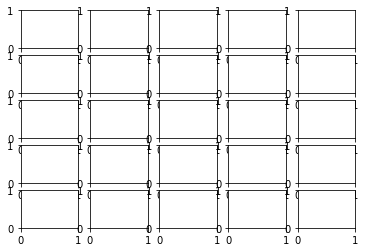

In [12]:
#fig , axs = plt.subplots(5,5)

In [55]:
gan = GAN()

I:\Anaconda3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 Discriminator loss0.986373 acc0.250000 Generator loss0.781112


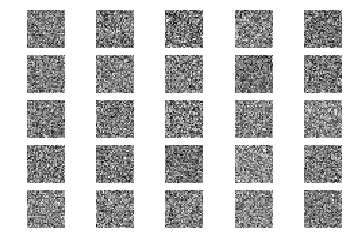

1 Discriminator loss0.389710 acc1.000000 Generator loss0.612240
2 Discriminator loss0.262184 acc1.000000 Generator loss0.444860


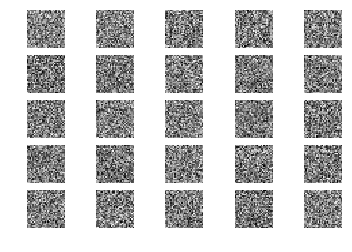

3 Discriminator loss0.298562 acc1.000000 Generator loss0.565592
4 Discriminator loss0.262334 acc1.000000 Generator loss0.559503


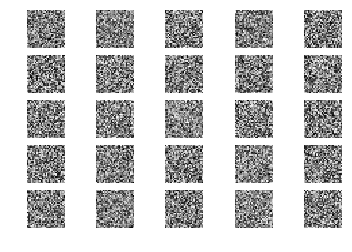

5 Discriminator loss0.165194 acc1.000000 Generator loss0.423373
6 Discriminator loss0.116456 acc1.000000 Generator loss0.300887


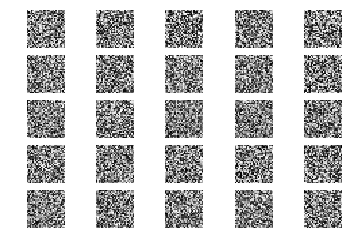

7 Discriminator loss0.114222 acc1.000000 Generator loss0.284062
8 Discriminator loss0.055003 acc1.000000 Generator loss0.319446


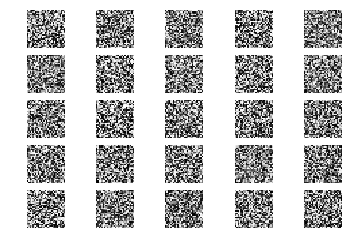

9 Discriminator loss0.035371 acc1.000000 Generator loss0.213682


In [56]:
gan.train(epochs=10 , batch_size=2 , sample_internal=2)